In [61]:
import torch.distributions as distributions
import torch
import torch.optim as optim
from torch.nn import Parameter, Module
import seaborn as sns

In [54]:
class Exponential(Module):
    
    def __init__(self, rate):
        super(Exponential, self).__init__()
        self.rate = Parameter(rate)
        self.model = distributions.Exponential(self.rate)
        
    def log_prob(self, x):
        return self.model.log_prob(x)
    
    def sample(self, size):
        return self.model.rsample(size)

    
class Normal(Module):
    
    def __init__(self, loc, scale):
        super(Normal, self).__init__()
        self.loc = Parameter(loc)
        self.scale = Parameter(scale)
        self.model = distributions.Normal(self.loc, self.scale)
        
    def log_prob(self, x):
        return self.model.log_prob(x)
    
    def sample(self, size):
        return self.model.rsample(size)

In [96]:
def visualize(q, p):
    q_samples = q.sample((10000,)).detach().reshape(-1).numpy()
    p_samples = p.sample((10000,)).detach().reshape(-1).numpy()
    sns.kdeplot(q_samples, cut=0)
    sns.kdeplot(p_samples, cut=0)

In [97]:
def ForwardKL(samples, distribution):
    return -distribution.log_prob(samples).sum()

def ReverseKL(q, p, batch_size=(64,1)):
    samples = q.sample(batch_size)
    return -(p.log_prob(samples) - q.log_prob(samples)).sum()

Epoch 0 Loss: 211.832
Epoch 1000 Loss: 138.388
Epoch 2000 Loss: 142.677
Epoch 3000 Loss: 131.693
Epoch 4000 Loss: 136.938
Epoch 5000 Loss: 129.922
Epoch 6000 Loss: 136.778
Epoch 7000 Loss: 144.651
Epoch 8000 Loss: 139.620
Epoch 9000 Loss: 138.496


3.200000047683716 2.299999952316284
0.36634087562561035


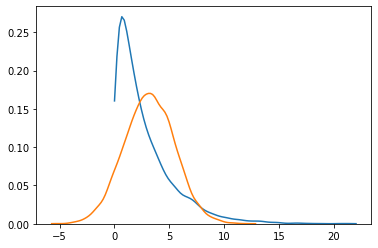

In [104]:
# Forward
model = Exponential(torch.tensor(1.0))
truth = Normal(torch.tensor([3.2]), torch.tensor([2.3]))

optimizer = optim.Adam(model.parameters(), lr=0.1)

for i in range(10000):
    optimizer.zero_grad()
    samples = truth.sample((64,1))
    loss = ForwardKL(samples, model)
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
        print(f"Epoch {i} Loss: {loss.item():.3f}")

print("\n")
print(truth.loc.item(), truth.scale.item())
print(model.rate.item())
visualize(model, truth)

Epoch 0 Loss: 77.424
Epoch 1000 Loss: 9.124
Epoch 2000 Loss: 43.909
Epoch 3000 Loss: 45.825
Epoch 4000 Loss: 28.952
Epoch 5000 Loss: 12.592
Epoch 6000 Loss: 15.226
Epoch 7000 Loss: 31.290
Epoch 8000 Loss: 18.217
Epoch 9000 Loss: 36.469


3.200000047683716 2.299999952316284
0.3820772171020508


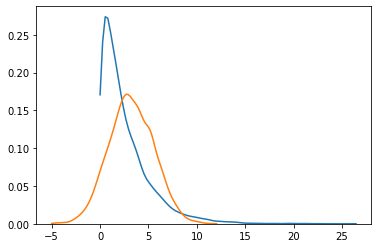

In [105]:
# Reverse
model = Exponential(torch.tensor(1.0))
truth = Normal(torch.tensor([3.2]), torch.tensor([2.3]))

optimizer = optim.Adam(model.parameters(), lr=0.01)

for i in range(10000):
    optimizer.zero_grad()
    loss = ReverseKL(model, truth)
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
        print(f"Epoch {i} Loss: {loss.item():.3f}")

print("\n")
print(truth.loc.item(), truth.scale.item())
print(model.rate.item())
visualize(model, truth)

Epoch 0 Loss: 137.674
Epoch 1000 Loss: 87.901
Epoch 2000 Loss: 102.248
Epoch 3000 Loss: 83.686
Epoch 4000 Loss: 84.866
Epoch 5000 Loss: 75.570
Epoch 6000 Loss: 81.452
Epoch 7000 Loss: 78.012
Epoch 8000 Loss: 74.588
Epoch 9000 Loss: 84.037


3.200000047683716 2.299999952316284
0.3803423047065735


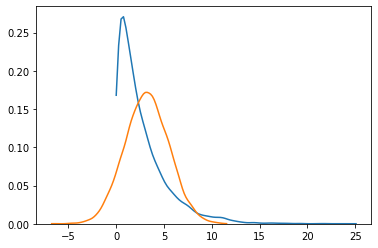

In [106]:
# Forward
model = Exponential(torch.tensor(1.0))
truth = Normal(torch.tensor([3.2]), torch.tensor([2.3]))

optimizer = optim.Adam(model.parameters(), lr=0.01)

for i in range(10000):
    optimizer.zero_grad()
    samples = truth.sample((64,1))
    loss = (ReverseKL(model, truth) + ForwardKL(samples, model))/2.0
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
        print(f"Epoch {i} Loss: {loss.item():.3f}")

print("\n")
print(truth.loc.item(), truth.scale.item())
print(model.rate.item())
visualize(model, truth)